In [1]:
import torch
import torch.nn as nn
import torch.utils as utils
from torch.autograd import Variable
import torchvision.datasets as dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
tensor_transform =  transforms.ToTensor()
transform=transforms.Compose([
    tensor_transform,
])
batch_size = 100

mnist_train = dataset.MNIST("./", train=True, transform=transform, target_transform=None, download=True)
mnist_val  = dataset.MNIST("./", train=False, transform=transform, target_transform=None, download=True)

# Set Data Loader(input pipeline)
train_loader = torch.utils.data.DataLoader(dataset=mnist_train,batch_size=batch_size,shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=mnist_val,batch_size=batch_size,shuffle=False)

In [3]:
'''
Function for generating noise that is going to be added to the inputs of the autoencoder
 :parameter
 mean  : float, scalar
 std   : float, scalar
 shape : tensor, shape (batch_size, num_channels, width, height)
 :returns
 noise : tensor, shape (batch_size, num_channels, width, height)
 return tensor with the Gaussian noise
'''
def gaussian_noise(mean, std, shape):
    noise = torch.randn(shape) * std + mean
    return noise

In [4]:
'''
Class for the Autoencoder model
'''
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder,self).__init__()
        # Encoder block
        self.layer1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=1)  
        self.layer2 = nn.BatchNorm2d(num_features=32)
        self.layer3 = nn.ReLU()
        self.layer4 = nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3, stride=2, padding=1)  
        self.layer5 = nn.BatchNorm2d(num_features=32)
        self.layer6 = nn.ReLU()
        self.layer7 = nn.Conv2d(in_channels=32, out_channels=64,kernel_size=3, stride=1, padding=1)
        
        # Decoder block
        self.layer8 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1) 
        self.layer9 = nn.BatchNorm2d(num_features=32)
        self.layer10 = nn.ReLU()
        self.layer11 = nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1) 
        self.layer12 = nn.BatchNorm2d(num_features=32)
        self.layer13 = nn.ReLU()  
        self.layer14 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, stride=1, padding=1)

                
    def forward(self,x):
        #image encoding
        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)
        x5 = self.layer5(x4)
        x6 = self.layer6(x5)
        encoded = self.layer7(x6)

        #image decoding
        '''
        pay attention to the "output_size" parameter of the Transposed convolutional in the forward pass.
        You need to pass it correctly in order to avoid missmatches between the sizes of output and ground truth 
        during the loss calculation.
        '''
        x8 = self.layer8(encoded, output_size = x1.shape)
        x9 = self.layer9(x8)
        x10 = self.layer10(x9)
        x11 = self.layer11(x10, output_size = x.shape)
        x12 = self.layer12(x11)
        x13 = self.layer13(x12)
        decoded = self.layer14(x13)
        return decoded

In [5]:
'''
Function for visualization of the loss values calculated during the training
:parameter
training_loss: list of scalars, training loss values of each epoch
val_loss: list of scalars, validation loss values of each epoch
'''
def plot_losses(train_loss, val_loss):

    epochs = range(1, len(train_loss) + 1)

    plt.plot(epochs, train_loss, '--', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

Training loss -  0.017935729067151743  Validation loss -  0.012968418290838599
Training loss -  0.012302098299066226  Validation loss -  0.011470613870769739
Training loss -  0.01155514569953084  Validation loss -  0.011101290201768279
Training loss -  0.011097069188642006  Validation loss -  0.010758640998974443
Training loss -  0.010840286184102297  Validation loss -  0.010477144382894038


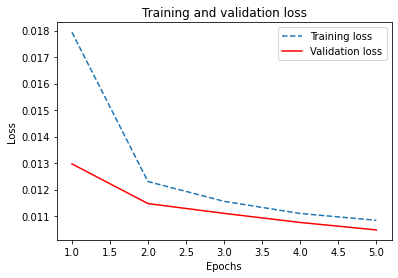

In [6]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
    
learning_rate = 0.001
epoch = 5

model = AutoEncoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
input_shape = (batch_size, 1, 28, 28)
'''
Pay attention that for the validation set we are generating noise once, to do a consistent calculation of
the validation loss (i.e. to calculate validation loss on the same input data)
'''
val_noise = gaussian_noise(mean=0, std=0.5, shape=input_shape)

training_losses = []
validation_losses = []
for i in range(epoch):
    model.train()
    epoch_loss_train = 0
    epoch_loss_val = 0
    for image,label in train_loader:
        ground_truth_batch = Variable(image).to(device)
        '''
        Pay attention that for the training set we are generating noise at for every batch.
        This can act as a data augmentation.
        '''
        train_noise = gaussian_noise(mean=0, std=0.5, shape=input_shape)
        input_batch = image + train_noise
        input_batch = Variable(input_batch).to(device)

        optimizer.zero_grad()
        output_batch = model(input_batch)

        loss = criterion(output_batch,ground_truth_batch)
        loss.backward()
        optimizer.step()
        epoch_loss_train += loss.item()
        
    training_losses.append(epoch_loss_train / len(train_loader))
    
    model.eval()
    for val_image, label in val_loader:
        ground_truth_batch = Variable(val_image).to(device)
        
        input_batch = val_image + val_noise
        input_batch = Variable(input_batch).to(device)

        output_batch = model(input_batch)

        val_loss = criterion(output_batch,ground_truth_batch)
        epoch_loss_val += val_loss.item()
    validation_losses.append(epoch_loss_val / len(val_loader))
              
                
    print("Training loss - ",epoch_loss_train / len(train_loader),
          " Validation loss - ", epoch_loss_val / len(val_loader))

plot_losses(train_loss=training_losses, val_loss=validation_losses)

torch.Size([1, 28, 28])


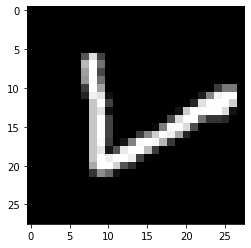

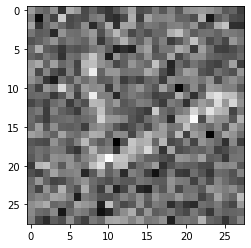

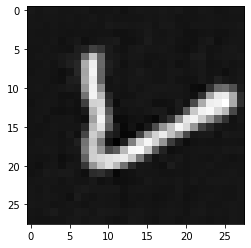

tensor(7)


In [7]:
'''
In this code snippet we will take random sample from the validation set and visualize its noisy version and the
restored version obtained via the trained model
'''
model.eval()
images, labels = next(iter(val_loader))   

noisy_image = images[0:1] + val_noise[0:1]
result = model(noisy_image.to(device))
origin = images[0].transpose(0,2).detach().cpu().numpy()
noisy =  noisy_image[0].transpose(0,2).detach().cpu().numpy()
result = result[0].transpose(0,2).detach().cpu().numpy()

plt.imshow(origin,cmap='gray')
plt.show()

plt.imshow(noisy,cmap='gray')
plt.show()

plt.imshow(result,cmap="gray")
plt.show()

print(labels[0])